In [1]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, SNR_plot, network_sender_receiver
from filters import butter_lowpass
import numpy as np
import matplotlib.pyplot as plt
import torch
from NetworkPytorch import joint_train_loop
from DE_Pytorch import DE
from scipy import signal
import scipy
import torchaudio
from scipy.stats import norm
from commpy import rcosfilter

In [2]:
def get_data():

    upsampled = CS.upsample()
    X_tx = torch.Tensor(upsampled).view(1, 1, -1)
    classes = np.array(symbol_set)
    y = symbol_seq
    class_idx = {v: i for i, v in enumerate(classes)}
    y_idx = np.array([class_idx[v] for v in y])
    y = torch.Tensor(y_idx)
    
    return X_tx, y

In [3]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 100000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)

# Create 1D Convolutional Neural Networks for transmitter and receiver and define optimizer and loss
# Remember to double check padding and general design of NN_tx and NN_rx

Xtrain, ytrain = get_data()
Xtest, ytest = get_data()

NN_tx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64, padding=len(CS.h)-1)) # padding=len(CS.h) - 1
NN_rx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
criterion = torch.nn.CrossEntropyLoss()
params = list(NN_tx.parameters()) + list(NN_rx.parameters())
optimizer = torch.optim.Adam(params, lr=1e-2)

In [ ]:
# Joint train sender and receiver NN using Backpropagation

epoch_losses = joint_train_loop(NN_tx, NN_rx, Xtrain, ytrain, optimizer, criterion, sample_rate=CS.m, 
                                epochs=200, cutoff_freq=0.55, v=True, use_cuda=False, SNRdb=6.5, plot_iteration=10,
                               lowpass='ideal')

plt.figure(figsize=(13, 8))
plt.plot(epoch_losses.to('cpu'))
plt.show()

In [ ]:
# Evaluate

accs = np.zeros(10)
accs_euclid = np.zeros(10)

for i in range(10):

    SNR = 6.5
    joint_decisions = CS.transmission(SNRdb=SNR, mode='joint', joint_cutoff=0.57, model=[NN_tx, NN_rx], lowpass='ideal')
    euclid_decisions = CS.transmission(SNRdb=SNR, mode='euclidean')
    acc = 1 - CS.evaluate(joint_decisions)[1]
    acc_euclid = 1 - CS.evaluate(euclid_decisions)[1]

    #print('Accuracy:', acc)
    #print('Accuracy:', 1 - CS.evaluate(euclid_decisions)[1])
    accs[i] = acc
    accs_euclid[i] = acc_euclid
    
print(np.mean(accs))
print(np.mean(accs_euclid))

In [13]:
NN_tx = torch.load('../Joint_Models/SenderIdeal0.57')
NN_rx = torch.load('../Joint_Models/ReceiverIdeal0.57')
#lf_tx_before = torch.load()

In [14]:
SNRdbs, euclid_er, network_er, NN_er, block_er, joint_er_ideal,  error_theory = \
SNR_plot(num_symbols=100000, joint_cutoff=0.57, joint_models=[NN_tx, NN_rx], lowpass='ideal', 
         range=[0, 19], num_SNRs=20) #[NN_tx, NN_rx]

Avg symbol energy 4.99984
gain 7.997651076371556


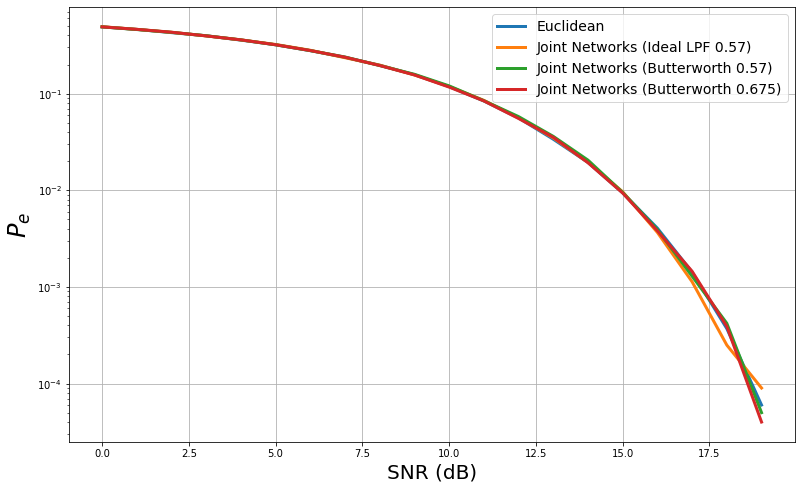

In [20]:
plt.figure(figsize=(13,8))
#plt.title('Noise Plot', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=24)
num = 0
plt.semilogy(SNRdbs[num:], euclid_er[num:], label='Euclidean', linewidth=3)
#plt.semilogy(SNRdbs[num:], NN_er[num:], label='NN Dec Maker')
#plt.semilogy(SNRdbs[num:], block_er[num:], label='Block')
#plt.semilogy(SNRdbs[num:], network_er[num:], label='Receiver Network')
plt.semilogy(SNRdbs[num:], joint_er_ideal[num:], label='Joint Networks (Ideal LPF 0.57)', linewidth=3)
plt.semilogy(SNRdbs[num:], joint_er_butter[num:], label='Joint Networks (Butterworth 0.57)', linewidth=3)
plt.semilogy(SNRdbs[num:], joint_er_butter0675[num:], label='Joint Networks (Butterworth 0.675)', linewidth=3)

#plt.semilogy(SNRdbs[num:], error_theory[num:], alpha=1, label='Theory', linewidth=3)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()
#plt.savefig('JointPerformanceAll', bbox_inches='tight', transparent=True)

## Plot Response of Whole System

In [ ]:
cutoff = 0.57
lowpass = 'butter'
b, a = butter_lowpass(cutoff_freq=cutoff, sampling_rate=CS.m, order=10)
learned_tx_filter = list(NN_tx.parameters())[0].detach()[0][0]
learned_rx_filter = list(NN_rx.parameters())[0].detach()[0][0]
if lowpass == 'butter':
    total_sender_response = scipy.signal.filtfilt(b, a, learned_tx_filter)
elif lowpass == 'ideal':
    total_sender_response = ideal_lowpass(learned_tx_filter, cutoff, CS.m)
total_sender_response = total_sender_response / np.sqrt(np.sum(np.square(total_sender_response))) # normalize
full_response = np.convolve(total_sender_response, learned_rx_filter)
full_response = full_response / np.sqrt(np.sum(np.square(full_response))) # normalize
raised = np.convolve(CS.h, CS.h)
#raised = rcosfilter(N=127, alpha=0.35, Ts=1, Fs=m)[1]
raised /= np.sqrt(np.sum(np.square(raised)))


figsize = (13, 8)
plt.figure(figsize=figsize)
plt.title('Full Reponse of System (Time)', fontsize=16)
plt.plot(-full_response, label='Learned Full Response')
plt.plot(raised, label='Raised Cosine')
plt.ylabel('Amplitude', fontsize=16)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

plt.figure(figsize=figsize)
plt.title('Full Sender Response (Frequency)', fontsize=20)
plt.magnitude_spectrum(full_response, Fs=8, scale='dB', sides='twosided', color='C1', label='Learned Full Response')
plt.magnitude_spectrum(raised, Fs=8, scale='dB', sides='twosided', color='C2', label='Raised Cosine')
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Magnitude (dB)', fontsize=16)
plt.ylim([-130, 0])
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

## Plot Sender Response

In [ ]:
figsize = (13, 8)
cutoff = 0.55
b, a = butter_lowpass(cutoff_freq=cutoff, sampling_rate=CS.m, order=10)
learned_filter = list(NN_tx.parameters())[0].detach()[0][0]
learned_filter = learned_filter / torch.sqrt(torch.sum(torch.square(learned_filter))) # normalize
total_sender_response = scipy.signal.filtfilt(b, a, learned_filter)
total_sender_response = total_sender_response / np.sqrt(np.sum(np.square(total_sender_response))) # normalize

plt.figure(figsize=figsize)
plt.title('Full Sender Response (Time)', fontsize=20)
plt.plot(total_sender_response)
plt.ylabel('Amplitude', fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.title('Full Sender Response (Frequency)', fontsize=20)
plt.magnitude_spectrum(total_sender_response, Fs=8, scale='dB', sides='twosided', color='C1')
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Magnitude (dB)', fontsize=16)
plt.ylim([-130, 0])
plt.show()